In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.2.0


In [3]:
train_image_path = glob.glob('datasets/dc/train/*/*.jpg')

In [4]:
len(train_image_path)

2000

In [5]:
keras = tf.keras

In [6]:
layers = tf.keras.layers

In [7]:
train_image_path[:5]

['datasets/dc/train\\cat\\cat.0.jpg',
 'datasets/dc/train\\cat\\cat.1.jpg',
 'datasets/dc/train\\cat\\cat.10.jpg',
 'datasets/dc/train\\cat\\cat.100.jpg',
 'datasets/dc/train\\cat\\cat.101.jpg']

In [8]:
train_image_path[-5:]

['datasets/dc/train\\dog\\dog.995.jpg',
 'datasets/dc/train\\dog\\dog.996.jpg',
 'datasets/dc/train\\dog\\dog.997.jpg',
 'datasets/dc/train\\dog\\dog.998.jpg',
 'datasets/dc/train\\dog\\dog.999.jpg']

In [9]:
p = 'dataseus/dc/train\\dog\\dog.995.jpg'

In [10]:
# 划分属于猫狗训练集
int(p.split('\\')[1] == 'cat')

0

In [11]:
# 得到相应的标签 0为狗 1 为猫
train_image_label = [int(p.split('\\')[1] == 'cat') for p in train_image_path]

In [12]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [13]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    # 解码数据，channel默认是0 彩色为3
    image = tf.image.decode_jpeg(image, channels=3)
    # 统一把图像转换成360
    image = tf.image.resize(image, [256, 256])
    # 图像增强 随机裁剪图片大小
    image = tf.image.random_crop(image, [256, 256, 3])
    # 随机翻转 左右翻转
    image = tf.image.random_flip_left_right(image)
    # 随机翻转 上下翻转
    image = tf.image.random_flip_up_down(image)
    # 随机亮度 最大亮度为0.5
    image = tf.image.random_brightness(image, 0.5)
    # 随机对比度
    image = tf.image.random_contrast(image, 0, 1)
    # 图像转换数据类型同时进行归一化
    image = tf.cast(image, tf.float32)
    image = image/255
    return image, label

In [14]:
#[1, 2, 3]  -->  [[1], [2], [3]] 每个样本 作为单独维度

In [15]:
#tf.image.convert_image_dtype 如果元数据是float则不做归一化

In [16]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [17]:
# 根据计算机的性能使用CPU的个数
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
# 在处理的时候，让这个函数应用在所有图像上
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [19]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

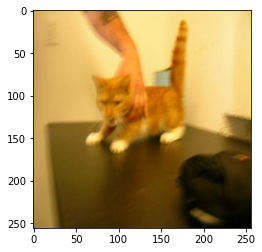

In [20]:
for img, label in train_image_ds.take(1):
    plt.imshow(img)

In [21]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [22]:
# 在train_count范围进行乱序
train_image_ds = train_image_ds.shuffle(train_count).repeat().batch(BATCH_SIZE)
# prefetch 在后台读取多少个数据 预处理一些数据，加速读取过程
train_image_ds = train_image_ds.prefetch(AUTOTUNE)

In [23]:
imgs,labels = next(iter(train_image_ds))

In [24]:
imgs.shape

TensorShape([32, 256, 256, 3])

In [25]:
test_image_path = glob.glob('datasets/dc/test/*/*.jpg')
test_image_label = [int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)

In [26]:
test_count=len(test_image_path)

In [27]:
labels.shape

TensorShape([32])

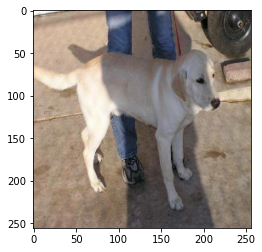

In [28]:
plt.imshow(imgs[0])

keras内置经典神经网络实现

In [30]:
# 就是不要分类器这个顶层
covn_base = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top=False,
                                                 input_shape=(256,256,3),
                                                 pooling='avg')

In [32]:
# 设置卷积层为不可训练
covn_base.trainable = False
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [33]:
model = keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [35]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
             loss='binary_crossentropy',
             metrics=['acc'])

In [ ]:
histroy = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=5,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)

# 微调

In [ ]:
# 解冻卷积层
covn_base.trainable = True

In [ ]:
# 查看一下层数
len(covn_base.layers)

In [ ]:
# 结束关闭层的界限
fine_tune_at = -3

In [ ]:
# 将倒数第三层之前的全部关闭
for layer  in covn_base.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005/10),
             loss='binary_crossentropy',
             metrics=['acc'])

In [ ]:
initial_epochs = 12
fine_time_epochs =10
total_epochs =initial_epochs + fine_time_epochs

histroy = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=intial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)